In [1]:
!pip install transformers datasets accelerate bitsandbytes sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.1 MB/s eta 0:00:00


In [1]:
%cd /content
%rm -rf /content/Forgetful-Transformers
!git clone https://github.com/IsaacRe/Forgetful-Transformers.git -b llama-scissorhands
%cd /content/Forgetful-Transformers

/content
Cloning into 'Forgetful-Transformers'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 76 (delta 44), reused 57 (delta 25), pack-reused 0
Receiving objects: 100% (76/76), 1.56 MiB | 4.72 MiB/s, done.
Resolving deltas: 100% (44/44), done.
/content/Forgetful-Transformers


In [2]:
from transformers.models.llama.modeling_llama import LlamaAttention
from typing import Tuple, Optional
from tqdm.auto import tqdm
import types
import torch
import torch.nn.functional as F
import torch.nn as nn
import warnings
import math


class LayerCounter:
    def __init__(self, n_layer: int = 32) -> None:
        self.n_layer = n_layer
        self.ctr = 0

    def increment(self):
        self.ctr = (self.ctr + 1) % self.n_layer

    def is_control(self):
        return self.ctr in CONFIG.control_layers

    def reset(self):
        self.ctr = 0


class Globals:
    def __init__(self, n_layer: int = 32) -> None:
        self.layer_ctr = LayerCounter(n_layer=n_layer)
        self.vars = {}

    def reset(self):
        self.layer_ctr.reset()
        self.vars = {}

    def append_or_add_listvar(self, key, value):
        if key not in self.vars:
            self.vars[key] = []
        self.vars[key] += [value]


def consolidate_window_iterative(attn_weights: torch.Tensor):
    window_size = max(1, CONFIG.consolidate_range[1] - CONFIG.num_sinks)
    ones = torch.ones(attn_weights.shape[-2:], device=attn_weights.device, dtype=torch.bool)
    sliding_window_mask = ~torch.tril(
        ones, diagonal=-window_size - 1  # active token doesn't contribute to cache size
    ) & torch.tril(ones)
    sliding_window_mask[:,:CONFIG.num_sinks] = True  # preserve attention sinks
    attn_weights[...,~sliding_window_mask] = 0

    # rescale attention matrix
    sums = attn_weights.sum(dim=-1)

    return attn_weights / sums[...,None]


"""Keep last n keys"""
def consolidate_window(attn_weights: torch.Tensor):
    window_start = int(CONFIG.consolidate_range[1] * CONFIG.consolidate_ratio)
    attn_weights[...,CONFIG.fit_range[1]:,CONFIG.num_sinks:window_start] = 0

    #print(f'Consolidated {max(0, window_start - CONFIG.num_sinks)} keys')

    # rescale
    sums = attn_weights.sum(dim=-1)
    sums[sums == 0] = 1

    return attn_weights / sums[...,None]


"""Simulate iterative key eviction of scissorhands during autoregressive generation"""
def consolidate_scissorhands_iterative(attn_weights: torch.Tensor):
    rescaled_attn = attn_weights * (1 + torch.arange(attn_weights.shape[-1]).to(CONFIG.device))[None,None,:,None]
    cummax = rescaled_attn.cummax(dim=-2).values

    # iterate through queries following max cache index, evicting keys as we go
    # start at postition = 1 + cache_size (since current token doesnt contribute to active cache size)
    start_pos = CONFIG.consolidate_range[1] + 1
    cummax_evicted_src = torch.ones_like(cummax) * float("inf")
    for pos in range(start_pos, attn_weights.shape[-1]):
        future_positions = attn_weights.shape[-1] - pos

        # protect most recent keys from eviction
        assert pos - CONFIG.num_protected > 0
        min_idx = cummax[...,pos-1,:pos-CONFIG.num_protected].min(dim=-1).indices

        # simulate eviction of min attention key (set future attention weights for this key to 0)
        idx_tensor = min_idx[...,None,None].repeat(1, 1, future_positions, 1).type(torch.int64)
        future_attn = attn_weights[...,pos:,:]
        future_attn.scatter_(dim=-1, index=idx_tensor, src=torch.zeros_like(future_attn))

        # set future rescaled attn weights for evicted key to inf so they won't be selected for eviction in future
        idx_tensor = min_idx[...,None,None].repeat(1, 1, cummax.shape[-1], 1).type(torch.int64)
        cummax.scatter_(dim=-1, index=idx_tensor, src=cummax_evicted_src)

    # rescale attention matrix
    sums = attn_weights.sum(dim=-1)

    return attn_weights / sums[...,None]


"""Apply scissorhands (https://arxiv.org/pdf/2305.17118.pdf) to prune keys exhibiting low attention"""
def consolidate_scissorhands(attn_weights: torch.Tensor):
    consolidate_up_to = CONFIG.consolidate_range[1] - CONFIG.min_fit_offset
    # adjust consolidation ratio if protecting last n tokens
    consolidate_ratio = min(1.0, CONFIG.consolidate_ratio * CONFIG.consolidate_range[1] / consolidate_up_to)
    c_range = slice(CONFIG.num_sinks, consolidate_up_to)
    f_range = slice(*CONFIG.fit_range)

    #offset_masked_attn = torch.tril(attn_weights, diagonal=-CONFIG.min_fit_offset)

    # scale attention weights by total number of available queries
    rescaled_attn = attn_weights * (1 + torch.arange(attn_weights.shape[-1]).to(CONFIG.device))[None,None,:,None]

    consolidate_attn = rescaled_attn[...,f_range,c_range]
    max_activations = consolidate_attn.max(dim=-2).values  # [batch X heads X keys]

    if CONFIG.dynamic_threshold:
        thresholds = torch.quantile(max_activations.type(torch.float32), consolidate_ratio, dim=-1)
        if CONFIG.record_consolidation_threshold:
            varname = f'layer{GLOBALS.layer_ctr.ctr}_consolidation_threshold'
            GLOBALS.append_or_add_listvar(varname, thresholds.mean())
        evict_mask = max_activations < thresholds[...,None]
    else:
        t = CONFIG.consolidate_threshold
        if isinstance(t, list):
            t = t[GLOBALS.layer_ctr.ctr]
        evict_mask = max_activations < t
        if CONFIG.record_consolidation_rate:
            varname = f'layer{GLOBALS.layer_ctr.ctr}_consolidation_rate'
            GLOBALS.append_or_add_listvar(varname, evict_mask.sum() / evict_mask.numel())

    attn_T = attn_weights.transpose(-2, -1)
    attn_T[...,c_range,CONFIG.fit_range[1]:][evict_mask] = 0

    #GLOBALS.vars['attn'] = attn_weights
    #GLOBALS.vars['mask'] = evict_mask
    attn_weights = attn_T.transpose(-2, -1)

    #print(f'consolidated layer {GLOBALS.layer_ctr.ctr}')
    #print(f'for {CONFIG.consolidate_range[1]} keys, evicted: {evict_mask.sum(dim=-1)}')

    # rescale
    sums = attn_weights.sum(dim=-1)
    sums[sums == 0] = 1

    return attn_weights / sums[...,None]


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`):
            The position indices of the tokens corresponding to the query and key tensors. For example, this can be
            used to pass offsetted position ids when working with a KV-cache.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos[position_ids].unsqueeze(unsqueeze_dim)
    sin = sin[position_ids].unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def modify_llama_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            modify_llama_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                modified_llama_attn_forward, model._modules[name]
            )


# transformers 4.35.2
def modified_llama_attn_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Tuple[torch.Tensor]] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    if "padding_mask" in kwargs:
        warnings.warn(
            "Passing `padding_mask` is deprecated and will be removed in v4.37. Please make sure use `attention_mask` instead.`"
        )

    bsz, q_len, _ = hidden_states.size()

    if self.config.pretraining_tp > 1:
        key_value_slicing = (self.num_key_value_heads * self.head_dim) // self.config.pretraining_tp
        query_slices = self.q_proj.weight.split(
            (self.num_heads * self.head_dim) // self.config.pretraining_tp, dim=0
        )
        key_slices = self.k_proj.weight.split(key_value_slicing, dim=0)
        value_slices = self.v_proj.weight.split(key_value_slicing, dim=0)

        query_states = [F.linear(hidden_states, query_slices[i]) for i in range(self.config.pretraining_tp)]
        query_states = torch.cat(query_states, dim=-1)

        key_states = [F.linear(hidden_states, key_slices[i]) for i in range(self.config.pretraining_tp)]
        key_states = torch.cat(key_states, dim=-1)

        value_states = [F.linear(hidden_states, value_slices[i]) for i in range(self.config.pretraining_tp)]
        value_states = torch.cat(value_states, dim=-1)

    else:
        query_states = self.q_proj(hidden_states)
        key_states = self.k_proj(hidden_states)
        value_states = self.v_proj(hidden_states)

    query_states = query_states.view(bsz, q_len, self.num_heads, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, self.num_key_value_heads, self.head_dim).transpose(1, 2)

    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None:
        kv_seq_len += past_key_value[0].shape[-2]
    cos, sin = self.rotary_emb(value_states, seq_len=kv_seq_len)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)

    if past_key_value is not None:
        # reuse k, v, self_attention
        key_states = torch.cat([past_key_value[0], key_states], dim=2)
        value_states = torch.cat([past_key_value[1], value_states], dim=2)

    past_key_value = (key_states, value_states) if use_cache else None

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)

    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(self.head_dim)

    if attn_weights.size() != (bsz, self.num_heads, q_len, kv_seq_len):
        raise ValueError(
            f"Attention weights should be of size {(bsz, self.num_heads, q_len, kv_seq_len)}, but is"
            f" {attn_weights.size()}"
        )

    if attention_mask is not None:
        if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
            raise ValueError(
                f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
            )
        attn_weights = attn_weights + attention_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(query_states.dtype)

    ### Only apply to keys generated during this forward pass
    if (
        CONFIG.do_consolidate and
        not GLOBALS.layer_ctr.is_control()
    ):
        if CONFIG.consolidate_method == "scissorhands":
            # Apply scissorhands (https://arxiv.org/pdf/2305.17118.pdf) to prune keys exhibiting low attention
            if CONFIG.dynamic_range:
                attn_weights = consolidate_scissorhands_iterative(attn_weights)
            else:
                attn_weights = consolidate_scissorhands(attn_weights)
        elif CONFIG.consolidate_method == "window":
            if CONFIG.dynamic_range:
                attn_weights = consolidate_window_iterative(attn_weights)
            else:
                attn_weights = consolidate_window(attn_weights)
        else:
            raise Exception("Invalid consolidation method")
    ###

    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

    if self.config.pretraining_tp > 1:
        attn_output = attn_output.split(self.hidden_size // self.config.pretraining_tp, dim=2)
        o_proj_slices = self.o_proj.weight.split(self.hidden_size // self.config.pretraining_tp, dim=1)
        attn_output = sum([F.linear(attn_output[i], o_proj_slices[i]) for i in range(self.config.pretraining_tp)])
    else:
        attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    ### Increment layer
    GLOBALS.layer_ctr.increment()
    ###

    return attn_output, attn_weights, past_key_value

In [3]:
from config import Config
token_offset = 0
consolidate_length = 1000
CONFIG = Config(
    batch_size=1,
    effective_batch_size=1,
    do_consolidate=True,
    consolidate_method="scissorhands",
    control_layers=[],
    context_length=2000,
    consolidate_ratio=0.5,
    consolidate_range=[0, consolidate_length],
    fit_range=[token_offset, consolidate_length + token_offset],
    min_fit_offset=token_offset,
    device='cuda:0',
)
CONFIG.record_consolidation_rate = True
CONFIG.record_consolidation_threshold = True
CONFIG.consolidate_threshold = 1.0
CONFIG.dynamic_threshold = True
CONFIG.dynamic_range = False
CONFIG.num_sinks = 4
GLOBALS = Globals()

In [4]:
from transformers import LlamaForCausalLM, LlamaTokenizer, BitsAndBytesConfig
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
model_name = 'NousResearch/Llama-2-7b-hf'
# q_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_use_double_quant=True,
#     bnb_4bit_quant_type="nf4",
#     bnb_4bit_compute_dtype=torch.bfloat16
# )
model = LlamaForCausalLM.from_pretrained(model_name,
                                         #quantization_config=q_config,
                                         load_in_8bit=True,
                                         device_map='cuda:0',
)
tokenizer = LlamaTokenizer.from_pretrained(model_name)

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:381: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:386: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [6]:
modify_llama_attention(model)

In [7]:
data = load_dataset(
    "pg19", None, split="test", streaming=True
)

In [8]:
# load input_ids
n_samples = 100
inputs = []
for text in tqdm(map(lambda x: x['text'], data.take(n_samples)), total=n_samples):
    inputs += [{
        name: t.to(CONFIG.device)
        for name, t in tokenizer.batch_encode_plus(
            [text],
            return_tensors="pt",
            truncation=True,
            max_length=CONFIG.context_length,
        ).items()
    }]

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
no_loss_label = -100
def compute_loss(model_input):
    labels = model_input['input_ids'].clone()
    labels[:,:CONFIG.fit_range[1]] = no_loss_label
    out = model(**model_input, labels=labels)
    return out.loss

Benchmarking and Validation

In [10]:
CONFIG.do_consolidate = False
no_loss_label = -100
eval_idx = CONFIG.fit_range[1]
loss = 0
with torch.no_grad():
    for model_input in tqdm(inputs):
        labels = model_input['input_ids'].clone()
        labels[:,:eval_idx] = no_loss_label
        out = model(**model_input,
                    labels=labels)
        loss += out.loss

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
torch.exp(loss / len(inputs))  # ppl with no consolidation - 1st 100

tensor(6.7613, device='cuda:0')

In [12]:
ppl_full = torch.exp(loss / len(inputs))  # ppl with no consolidation

In [ ]:
torch.exp(loss / len(inputs))  # ppl with no consolidation

tensor(7.6081, device='cuda:0')

In [ ]:
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
CONFIG.consolidate_ratio = 0.0
loss = 0
with torch.no_grad():
    for model_input in tqdm(inputs):
        loss += compute_loss(model_input)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.exp(loss / len(inputs))  # validate ppl with no consolidation when attention hook

tensor(7.6100, device='cuda:0')

In [ ]:
CONFIG.do_consolidate = False
loss = 0
eval_idx = CONFIG.consolidate_range[1]
with torch.no_grad():
    for model_input in tqdm(inputs):
        labels = model_input['input_ids'].clone()
        out = model(**{k: v[:,eval_idx:] for k, v in model_input.items()},
                    labels=labels[:,eval_idx:])
        loss += out.loss

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.exp(loss / len(inputs))  # ppl with full consolidation

tensor(9.0135, device='cuda:0')

In [ ]:
no_loss_label = -100
CONFIG.do_consolidate = False
CONFIG.num_sinks = 4
loss = 0
eval_idx = CONFIG.consolidate_range[1]
with torch.no_grad():
    for model_input in tqdm(inputs):
        labels = model_input['input_ids'].clone()
        labels[:,:CONFIG.fit_range[1]] = no_loss_label
        attention_mask = model_input['attention_mask'].clone()
        attention_mask[:,CONFIG.num_sinks:CONFIG.consolidate_range[1]] = 0
        out = model(input_ids=model_input['input_ids'],
                    attention_mask=attention_mask,
                    labels=labels)
        loss += out.loss

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.exp(loss / len(inputs))  # full consolidation via attention masking

tensor(9.2265, device='cuda:0')

In [ ]:
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
CONFIG.consolidate_ratio = 1.0
loss = 0
eval_idx = CONFIG.fit_range[1]
with torch.no_grad():
    for model_input in tqdm(inputs):
        loss += compute_loss(model_input)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
torch.exp(loss / len(inputs))  # validate ppl with full consolidation by attention hook (lower bc inequality leads to one less key eviction)

tensor(9.1751, device='cuda:0')

Layer Sensitivity Analysis - fixed rate consolidation

In [ ]:
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
CONFIG.consolidate_ratio = 0.9
n_layer = 32
layers = [l for l in range(n_layer)]
methods = ['window', 'scissorhands']
pbar = tqdm(total=len(layers) * len(methods) * len(inputs))
method_loss = {}
with torch.no_grad():
    for m in methods:
        CONFIG.consolidate_method = m
        method_loss[m] = []
        for l in layers:
            CONFIG.control_layers = [l_ for l_ in range(n_layer) if l_ != l]
            loss = 0
            for model_input in inputs:
                loss += compute_loss(model_input)
                pbar.update(1)
            method_loss[m] += [torch.exp(loss / len(inputs)).item()]

  0%|          | 0/640 [00:00<?, ?it/s]

In [ ]:
import numpy as np
np.savez('ppl_by_layer_75.npz', **{m: np.array(l) for m, l in method_loss.items()})

Text(0.5, 0.98, 'PPL sensitivity by layer consolidation, ratio = 0.75')

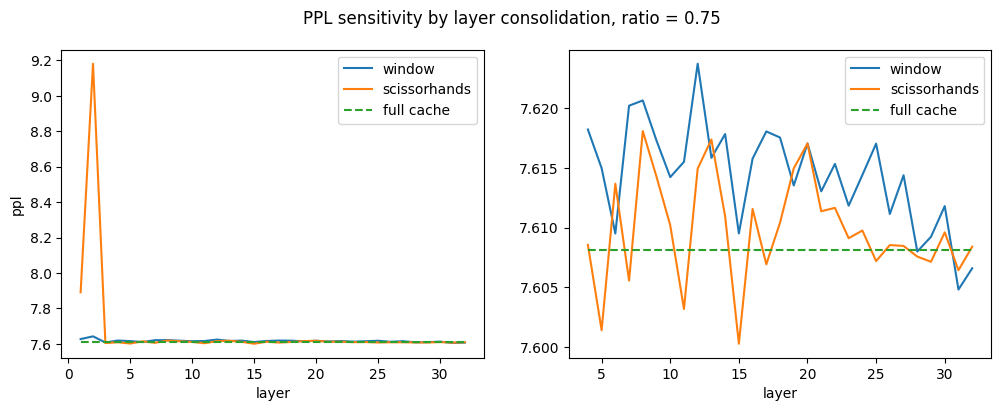

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for m, l in method_loss.items():
    ax[0].plot(list(range(1, n_layer + 1)), l, label=m)
ax[0].plot([1, 32], [7.6081, 7.6081], linestyle='--', label='full cache')
ax[0].legend()
ax[0].set_ylabel('ppl')
ax[0].set_xlabel('layer')
for m, l in method_loss.items():
    ax[1].plot(list(range(4, n_layer + 1)), l[3:], label=m)
ax[1].plot([4, 32], [7.6081, 7.6081], linestyle='--', label='full cache')
ax[1].legend()
ax[1].set_xlabel('layer')
f.suptitle('PPL sensitivity by layer consolidation, ratio = 0.75')

In [ ]:
import numpy as np
np.savez('ppl_by_layer_90.npz', **{m: np.array(l) for m, l in method_loss.items()})

Text(0.5, 0.98, 'PPL sensitivity by layer consolidation, ratio = 0.9')

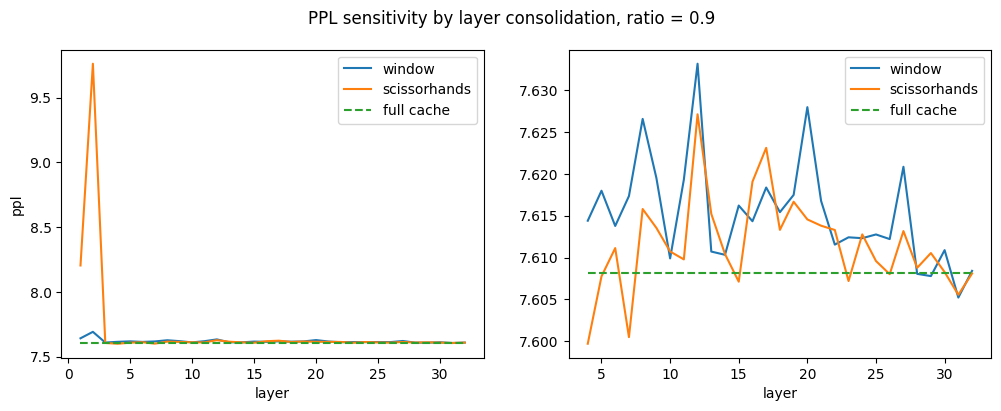

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))
for m, l in method_loss.items():
    ax[0].plot(list(range(1, n_layer + 1)), l, label=m)
ax[0].plot([1, 32], [7.6081, 7.6081], linestyle='--', label='full cache')
ax[0].legend()
ax[0].set_ylabel('ppl')
ax[0].set_xlabel('layer')
for m, l in method_loss.items():
    ax[1].plot(list(range(4, n_layer + 1)), l[3:], label=m)
ax[1].plot([4, 32], [7.6081, 7.6081], linestyle='--', label='full cache')
ax[1].legend()
ax[1].set_xlabel('layer')
f.suptitle('PPL sensitivity by layer consolidation, ratio = 0.9')

Takeaways
- Rolling cache with attention sinks outperforms scissorhands for first 2 layers
- Scissorhands consistently outperforms rolling cache for all other layers

Consolidation Rate Analysis



In [ ]:
CONFIG.do_consolidate = True
CONFIG.dynamic_threshold = True
CONFIG.num_sinks = 4
CONFIG.control_layers = [0, 1]
ratios = [0.0, 0.1, 0.25, 0.5, 0.75, 0.9, 1.0]
methods = ['window', 'scissorhands']
pbar = tqdm(total=len(ratios) * len(inputs) * len(methods))
method_loss = {}
with torch.no_grad():
    for m in methods:
        CONFIG.consolidate_method = m
        method_loss[m] = []
        for r in ratios:
            loss = 0
            CONFIG.consolidate_ratio = r
            for model_input in inputs:
                loss += compute_loss(model_input)
                pbar.update(1)
            method_loss[m] += [torch.exp(loss / len(inputs)).item()]

  0%|          | 0/140 [00:00<?, ?it/s]

Text(0.5, 1.0, 'PPL by consolidation ratio, consolidate layers 3-32')

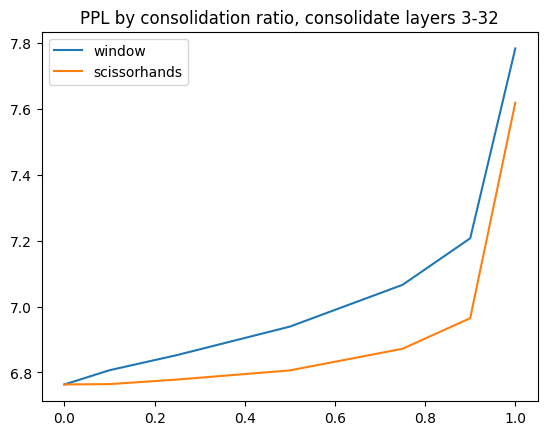

In [ ]:
for m, l in method_loss.items():
    plt.plot(ratios, l, label=m)
plt.legend()
plt.title('PPL by consolidation ratio, consolidate layers 3-32')

In [ ]:
np.savez('ppl_by_ratio_layers_3to32.npz', **{m: np.array(l) for m, l in method_loss.items()})

Text(0.5, 1.0, 'PPL by consolidation ratio, consolidate layers 3-32')

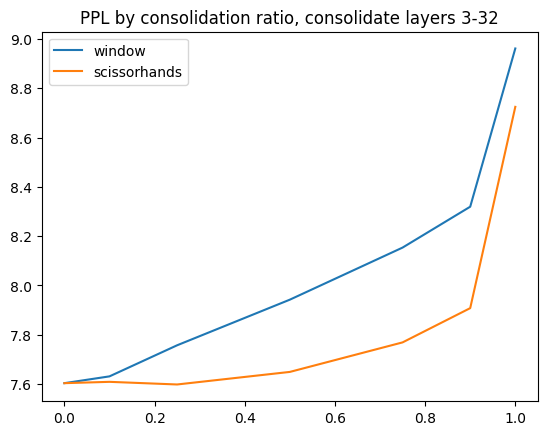

In [ ]:
for m, l in method_loss.items():
    plt.plot(ratios, l, label=m)
plt.legend()
plt.title('PPL by consolidation ratio, consolidate layers 3-32')

Layerwise Threshold Analysis

In [ ]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
CONFIG.consolidate_ratio = 0.5
CONFIG.consolidate_method = 'scissorhands'
CONFIG.control_layers = []

n_layer = 32
pbar = tqdm(total=len(inputs))
with torch.no_grad():
    loss = 0
    for model_input in inputs:
        loss += compute_loss(model_input)
        pbar.update(1)
consolidation_thresholds = [
    torch.stack(GLOBALS.vars[f'layer{l}_consolidation_threshold']).mean().item()
    for l in range(n_layer)
    if l not in CONFIG.control_layers
]
GLOBALS.reset()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
np.save('threshold_by_layer_50.npy', np.array(consolidation_thresholds))

Text(0.5, 1.0, 'Consolidation threshold by layer, fixed consolidation ratio = 0.5')

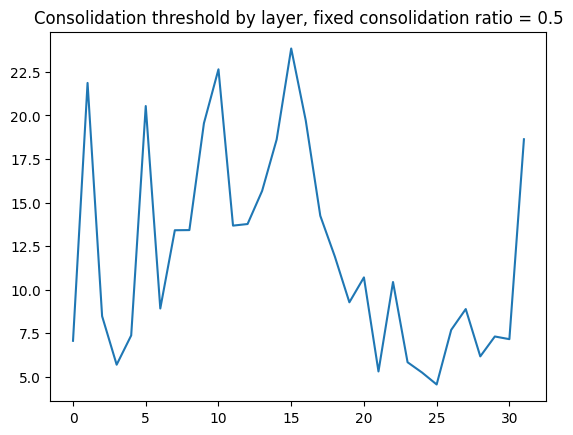

In [ ]:
plt.plot(consolidation_thresholds)
plt.title("Consolidation threshold by layer, fixed consolidation ratio = 0.5")

Dynamic Consolidation Rate Analysis

In [ ]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
thresholds = [0, 1, 4, 16, 64, 256, 1024]  # coefficient to be multiplied by 1/n_queries
CONFIG.consolidate_method = 'scissorhands'
CONFIG.dynamic_threshold = False
CONFIG.control_layers = [0, 1]
pbar = tqdm(total=len(thresholds) * len(inputs))
ppl = []
consolidation_rate = []
with torch.no_grad():
    for t in thresholds:
        CONFIG.consolidate_threshold = t
        loss = 0
        for model_input in inputs:
            loss += compute_loss(model_input)
            pbar.update(1)
        ppl += [torch.exp(loss / len(inputs)).item()]
        varname = f'layer{l}_consolidation_rate'
        consolidation_rate += [
            torch.tensor([
                GLOBALS.vars[f'layer{l}_consolidation_rate']
                for l in range(n_layer)
                if l not in CONFIG.control_layers
            ]).mean()
        ]
        GLOBALS.vars[varname] = []

  0%|          | 0/70 [00:00<?, ?it/s]

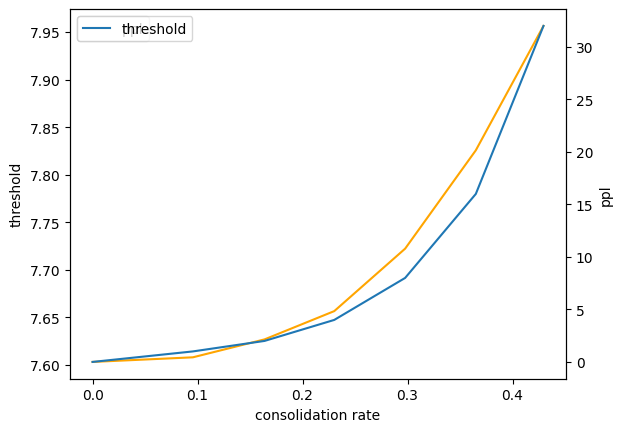

In [ ]:
ax1 = plt.axes()
ax = plt.twinx()
plt.plot(consolidation_rate, thresholds, label='threshold')
ax1.plot(consolidation_rate, ppl, label='ppl', c='orange')
ax1.set_ylabel('threshold')
ax1.set_xlabel('consolidation rate')
ax.set_ylabel('ppl')
plt.legend()
ax1.legend()
ax.legend()

Dynamic Consolidation Rate Analysis - rescale by layerwise thresholds (from above)

Note: failure here could suggest consistency in consolidation rate across heads is important

In [ ]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.num_sinks = 4
thresholds = [0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5]  # coefficient to be multiplied by 1/n_queries
CONFIG.consolidate_method = 'scissorhands'
CONFIG.dynamic_threshold = False
CONFIG.control_layers = [0, 1]
pbar = tqdm(total=len(thresholds) * len(inputs))
ppl = []
consolidation_rate = []
with torch.no_grad():
    for t in thresholds:
        CONFIG.consolidate_threshold = [t_ * t for t_ in consolidation_thresholds]
        loss = 0
        for model_input in inputs:
            loss += compute_loss(model_input)
            pbar.update(1)
        ppl += [torch.exp(loss / len(inputs)).item()]
        varname = f'layer{l}_consolidation_rate'
        consolidation_rate += [
            torch.tensor([
                GLOBALS.vars[f'layer{l}_consolidation_rate']
                for l in range(n_layer)
                if l not in CONFIG.control_layers
            ]).mean()
        ]
        GLOBALS.vars[varname] = []

  0%|          | 0/70 [00:00<?, ?it/s]

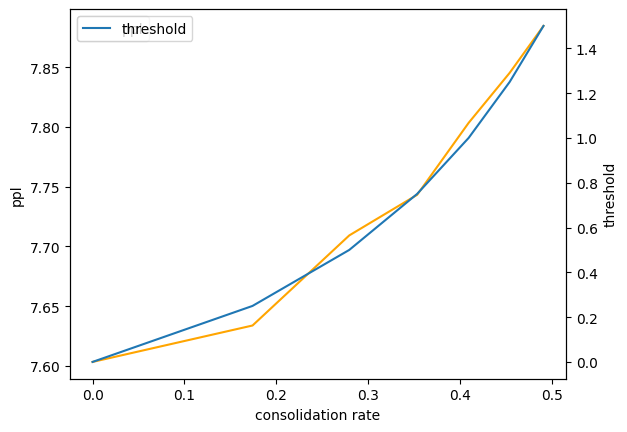

In [ ]:
ax1 = plt.axes()
ax = plt.twinx()
plt.plot(consolidation_rate, thresholds, label='threshold')
ax1.plot(consolidation_rate, ppl, label='ppl', c='orange')
ax.set_ylabel('threshold')
ax1.set_xlabel('consolidation rate')
ax1.set_ylabel('ppl')
plt.legend()
ax1.legend()
ax.legend()

Takeaways
- Evicting fixed number of keys per layer/head more effective than evicting variable number based on fixed threshold on the max rescaled attention weight
- PPL gains observed when fixing number of keys evicted per attention head as well as fixing per layer

Token Offset Exploration

In [ ]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.consolidate_method = 'scissorhands'
CONFIG.dynamic_threshold = True
CONFIG.num_sinks = 4
CONFIG.control_layers = [0, 1]
ratios = [0.5, 0.9]
offsets = [0, 4, 16, 64]
eval_idx = CONFIG.fit_range[1]
n_sample = 10
pbar = tqdm(total=len(offsets) * n_sample * len(ratios))
ppl_by_ratio = {}
with torch.no_grad():
    for r in ratios:
        ppl_by_ratio[r] = []
        CONFIG.consolidate_ratio = r
        for o in offsets:
            loss = 0
            CONFIG.min_fit_offset = o
            for model_input in inputs[:n_sample]:
                loss += compute_loss(model_input)
                pbar.update(1)
            ppl_by_ratio[r] += [torch.exp(loss / n_sample).item()]

  0%|          | 0/40 [00:00<?, ?it/s]

Text(0.5, 1.0, 'PPL by token consolidation offset')

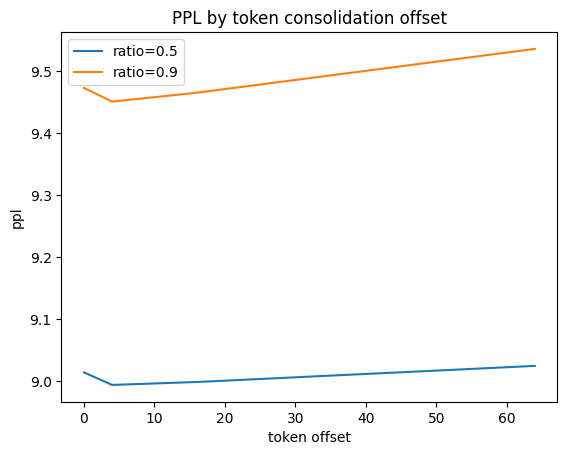

In [ ]:
for r, l in ppl_by_ratio.items():
    plt.plot(offsets, l, label=f'ratio={r}')
plt.legend()
plt.ylabel('ppl')
plt.xlabel('token offset')
plt.title("PPL by token consolidation offset")

Simulate consolidation with Scissorhands during autoregressive generation

In [13]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.consolidate_method = 'window' # 'scissorhands'
CONFIG.dynamic_range = True
CONFIG.num_sinks = 4
CONFIG.control_layers = [0, 1]
cache_sizes = [1000] #[600, 800, 1000, 1200, 2000]
n_sample = 100
pbar = tqdm(total=len(cache_sizes) * n_sample)
losses = []
with torch.no_grad():
    for size in cache_sizes:
        loss = 0
        CONFIG.consolidate_range[1] = size
        for model_input in inputs[:n_sample]:
            loss += compute_loss(model_input)
            pbar.update(1)
        losses += [torch.exp(loss / n_sample).item()]

  0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
ppl_window = losses[0]

In [ ]:
import numpy as np
np.savez('autoreg_scissorhands_ppl.npz', ppl=np.array(losses), cache_size=np.array(cache_sizes))

In [20]:
np.savez('autoreg_window_ppl.npz', ppl=np.array(losses), cache_size=np.array(cache_sizes))

In [17]:
import numpy as np
scissorhand_losses = np.load('autoreg_window_ppl.npz')['ppl']

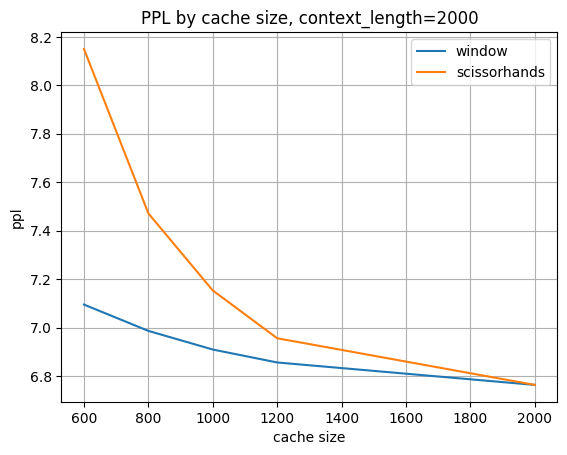

In [24]:
plt.plot(cache_sizes, losses, label='window')
plt.plot(cache_sizes, scissorhand_losses, label='scissorhands')
plt.title("PPL by cache size, context_length=2000")
plt.xlabel("cache size")
plt.ylabel("ppl")
plt.grid()
plt.legend()

Takeaways:
- In autoregressive case, sliding window outperforms scissorhands

In [23]:
GLOBALS.reset()
CONFIG.do_consolidate = True
CONFIG.consolidate_method = 'scissorhands'
CONFIG.dynamic_range = True
CONFIG.num_sinks = 4
CONFIG.control_layers = [0, 1]
CONFIG.consolidate_range[1] = 1000
n_protected_vals = [0, 1, 4, 16, 64, 256, 512, 768, 995]
n_sample = 100
pbar = tqdm(total=len(n_protected_vals) * n_sample)
losses = [7.153378009796143, 6.91420316696167, 6.84604549407959, 6.793196201324463, 6.781797409057617, 6.777413845062256, 6.777225017547607] #[]
with torch.no_grad():
    for n_protected in n_protected_vals[-2:]:
        loss = 0
        CONFIG.num_protected = n_protected
        for model_input in inputs[:n_sample]:
            loss += compute_loss(model_input)
            pbar.update(1)
        losses += [torch.exp(loss / n_sample).item()]

  0%|          | 0/900 [00:00<?, ?it/s]

In [26]:
import numpy as np
np.savez('scissorhands_ppl_by_protected_1000_2000.npz', ppl=losses, num_protected=n_protected_vals)

Text(0, 0.5, 'ppl')

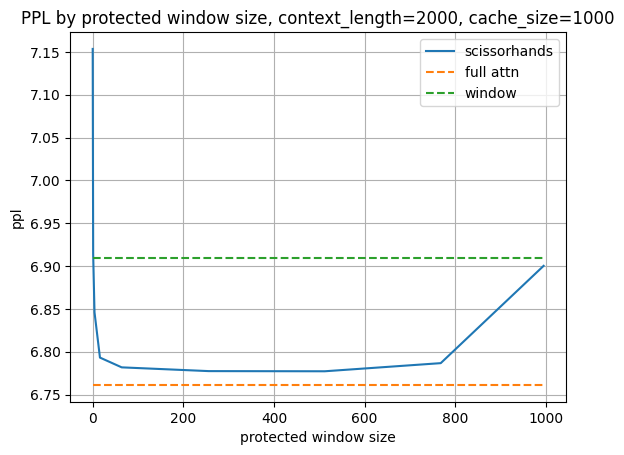

In [25]:
plt.plot(n_protected_vals, losses, label='scissorhands')
plt.plot([n_protected_vals[0], n_protected_vals[-1]], [ppl_full.item(), ppl_full.item()], label='full attn', linestyle='--')
plt.plot([n_protected_vals[0], n_protected_vals[-1]], [ppl_window, ppl_window], label='window', linestyle='--')
plt.legend()
plt.grid()
plt.title('PPL by protected window size, context_length=2000, cache_size=1000')
plt.xlabel('protected window size')
plt.ylabel('ppl')

Takeaways:
- Scissorhands without a protected window performs worse than windowed attention with sinks
- Adding a small sliding window in which token KVs are protected from cache eviction yields improvement far beyond naive windowed attention
- Optimal protected window size falls in range of 256-512 tokens (likely dependent on total cache size)